In [114]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network

# 1. Barabási - Albert hálózat

### 1.1 A meglévő gráfból kiválasztunk egy csomópontot a preferenciális kapcsolódás elve szerint

In [115]:
def BA_rand_prob_node():
    nodes_probs = [] # Ebbe a listába gyűjtjük a csomópontok valószínűségeit (azaz hogy mekkora eséllyel kapcsolódik hozzájuk az új csomópont)
    for node in G.nodes(): # Végig iterálok a gráf csomópontjain
        node_degr = G.degree(node) # Megállapítom adott csomópont fokszámát
        node_proba = node_degr / (2 * len(G.edges())) # Megállapítom a csomóponthoz társított valószínűséget
        nodes_probs.append(node_proba) # Hozzáadom ezt a valószínűséget a listámhoz
    random_proba_node = np.random.choice(G.nodes(),p=nodes_probs) # Véletlenszerűen választunk 1 csomópontot a gráfból a valószínűségek alapján
    return random_proba_node

### 1.2 Az új csomópontot összekötjük az 1. pontban kiválasztott csomóponttal

In [116]:
def add_edge():
    random_proba_node = BA_rand_prob_node() # Meghívjuk a kiválasztott csomópontot
    new_edge = (random_proba_node, uj_csomopont) # Az új él a kiválasztott csomópont és az új csomópont között legyen majd
    if new_edge in G.edges(): # Ha van már él köztük, akkor válasszunk másik csomópontot a gráfból
        add_edge()
    else:
        G.add_edge(uj_csomopont, random_proba_node) # Adjuk hozzá a gráfhoz az új élt

Végig iterálok az (N - kezdeti csomópontok) tartományon (ennyi új csomópontot adok hozzá a gráfhoz):
* A gráfhoz hozzáadom a soron következő csomópontot (20....1000)
* iterálok m tartományában (ennyi éllel csatlakozik majd a gráfhoz az új csomópont)
    * Hozzákapcsolom a gráfhoz m éllel az új csomópontot

In [117]:
kezdeti_csomopontok=20 # Kezdeti csomópontok száma
N=1000 # Összes csompópont
G=nx.erdos_renyi_graph(kezdeti_csomopontok,0.2) # Erdős-Rényi gráfból indulok
m_parameter=3

count = 0
uj_csomopont = kezdeti_csomopontok

for f in range(N - kezdeti_csomopontok):
    G.add_node(kezdeti_csomopontok + count)
    count += 1
    for e in range(0, m_parameter):
        add_edge()
    uj_csomopont += 1

### 1.3 Ábra a B-A gráfról

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


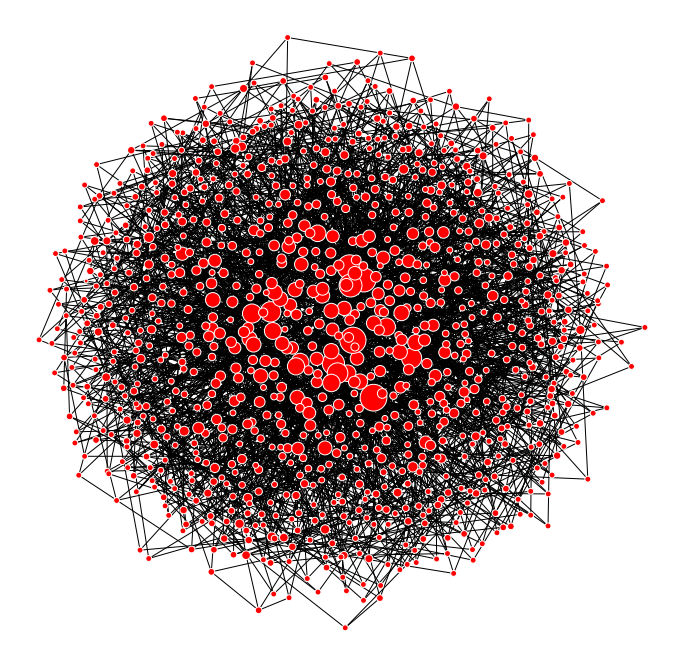

In [5]:
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(12,12))

sizes = [ 10*G.degree[node]+5 for node in G.nodes]

#prlist = [ns_pr[node] for node in cnsG.nodes]

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="r", edgecolors='#ffffff')

nx.draw_networkx_edges(G, pos, edge_color='#00000088')

# draw labels
#labels = {node:cnsG.nodes[node]['name'] for node in prtop10}
#nx.draw_networkx_labels(cnsG, ns_pos, labels=labels, font_size=12)

plt.axis('off');

In [119]:
h=Network(height=800, width=800, notebook=True)
h.from_nx(G())
h.show("proba.html")

TypeError: 'Graph' object is not callable

### 1.4 Fokszám Eloszlás

In [4]:
def k_distrib(graph, fit_line=False, expct_lo=1, expct_hi=10, expct_const=1):
    
    plt.close()
    num_nodes = graph.number_of_nodes()
    max_degree = 0
    
    # Megkeressük a legmagasabb fokszámot, ami alapján meghatározzuk az x-tengelyt
    for n in graph.nodes():
        if graph.degree(n) > max_degree:
            max_degree = graph.degree(n)
    
    # X és Y tengely értékei
    x = []
    y_tmp = []
    
    # Végigiterálok a legnagyobb fokszám terjedelmében és meghatározom az adott fokszámok arányait a csomópontok alapján
    for i in range(max_degree + 1):
        x.append(i)
        y_tmp.append(0)
        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp] 
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Fokszám eloszlás (log-log scale)')
    plt.ylabel('log(P(k))')
    plt.xlabel('log(k)')
    plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 4, color = 'purple', alpha = 1)
        
    if fit_line:
        w = [a for a in range(expct_lo,expct_hi)]
        z = []
        for i in w:
            x = (i**-3) * expct_const # Elméleti egyenes -3 meredekséggel és tetszőleges konstanssal
            z.append(x)
        plt.plot(w, z, 'k-', color='black')

    plt.show()

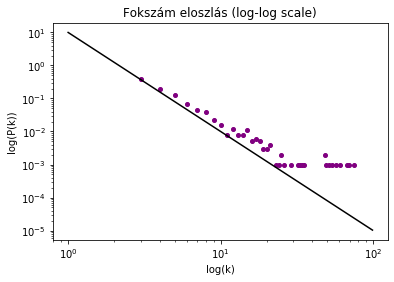

In [10]:
k_distrib(G, fit_line=True, expct_lo=1, expct_hi=100, expct_const=10)

# 2. Másolómodellel hálózat

### 2.1 A meglévő gráfból kiválasztunk egy csomópontot a másoló modell elve szerint

In [49]:
def COPY_rand_prob_node():
    
    nodes_probs = [] # Ebbe a listába gyűjtjük a csomópontok valószínűségeit (azaz hogy mekkora eséllyel kapcsolódik hozzájuk az új csomópont)
    copy_neighbors=[] # Ebbe a listába gyűjtjük a kiválasztott csomópont szomszédjait, akik közül választunk majd egyet
    
    while len(copy_neighbors)<1: # Itt az a szopás, hogy nem kéne szomszéd nélküli csomópontot választani. Erről nem írt a fáma, de nem tudom megkerülni hogy legyen szelekció az első lépcsőben.
        copy_node = np.random.choice(G.nodes()) # Véletlenszerűen választunk 1 csomópontot a gráfból
        copy_neighbors=list(G.neighbors(copy_node)) # Beteszem egy listába a kiválasztott csomópont szomszédjait
    
    for i in range(len(copy_neighbors)): # Végig iterálok ezeken a csomópontokon
        node_degr = G.degree(i) # Meghatározom a fokszámukat
        node_proba = node_degr / (2 * len(G.edges())) # Megállapítom a csomópontokhoz társított valószínűségeket
        nodes_probs.append(node_proba) # Amiket hozzáadok a listámhoz
    
    p = np.array(nodes_probs) # Beleteszem a valószínűséegeket a p arraybe
    p /= p.sum()  # normalizálom őket, mert a random choice-nál 1 kell legyen a szumma
    random_proba_node=np.random.choice(copy_neighbors,p=p)
    # Véletlenszerűen választunk 1 csomópontot a szomsszédok közül, a valószínűségek alapján
    
    return random_proba_node

### 2.2 Az új csomópontot összekötjük az 1. pontban kiválasztott csomóponttal

In [50]:
def add_edge():
    random_proba_node = COPY_rand_prob_node() # Meghívjuk a kiválasztott csomópontot
    new_edge = (random_proba_node, uj_csomopont) # Az új él a kiválasztott csomópont és az új csomópont között legyen majd
    if new_edge in G.edges(): # Ha van már él köztük, akkor válasszunk másik csomópontot a gráfból
        add_edge()
    else:
        G.add_edge(uj_csomopont, random_proba_node) # Adjuk hozzá a gráfhoz az új élt

Végig iterálok az (N - kezdeti csomópontok) tartományon (ennyi új csomópontot adok hozzá a gráfhoz):
* A gráfhoz hozzáadom a soron következő csomópontot (20....1000)
* iterálok m tartományában (ennyi éllel csatlakozik majd a gráfhoz az új csomópont)
    * Hozzákapcsolom a gráfhoz m éllel az új csomópontot

In [51]:
kezdeti_csomopontok=20 # Kezdeti csomópontok száma
N=1000 # Összes csompópont
G=nx.erdos_renyi_graph(kezdeti_csomopontok,0.2) # Erdős-Rényi gráfból indulok
m_parameter=3

count = 0
uj_csomopont = kezdeti_csomopontok

for f in range(N - kezdeti_csomopontok):
    G.add_node(kezdeti_csomopontok + count)
    count += 1
    for e in range(0, m_parameter):
        add_edge()
    uj_csomopont += 1

### 2.3 Ábra a gráfról

In [87]:
def graf_abra(G):   
    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(12,12))
    
    sizes = [ 10*G.degree[node]+5 for node in G.nodes]
    
    #prlist = [ns_pr[node] for node in cnsG.nodes]
    
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="r", edgecolors='#ffffff')
    
    nx.draw_networkx_edges(G, pos, edge_color='#00000088')
    
    # draw labels
    #labels = {node:cnsG.nodes[node]['name'] for node in prtop10}
    #nx.draw_networkx_labels(cnsG, ns_pos, labels=labels, font_size=12)
    
    plt.axis('off');

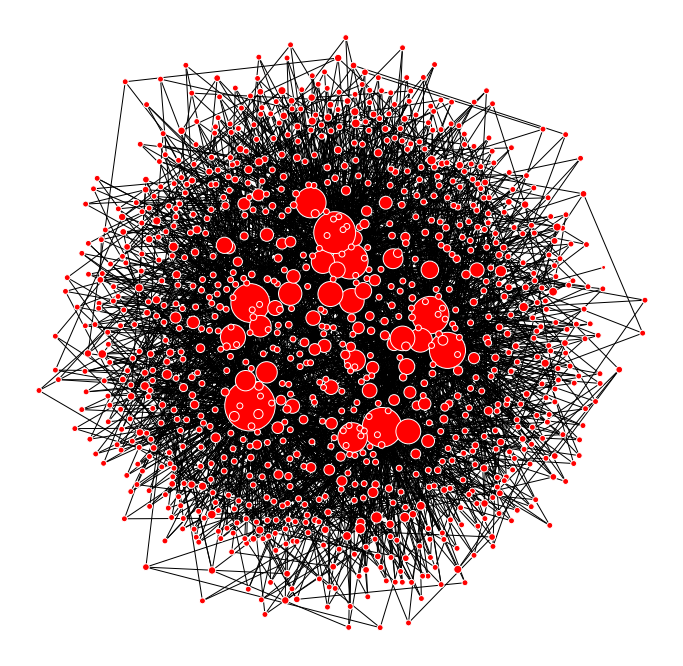

In [59]:
graf_abra(G)

### 2.4 Fokszám Eloszlás

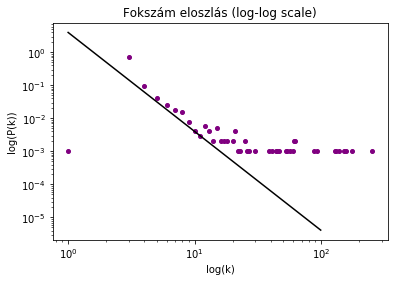

In [57]:
k_distrib(G, fit_line=True, expct_lo=1, expct_hi=100, expct_const=4)

# 3. Kapcsolatválasztó modellel hálózat

In [81]:
def LINK_rand_prob_node():
    a=np.random.randint(0,len(G.edges())) # Választok egy élt
    b=list(G.edges())[a] # Beteszem egy listába a pontokat
    random_proba_node=np.random.choice(b) # Kiválasztom az egyiket
    return random_proba_node

In [82]:
def add_edge():
    random_proba_node = LINK_rand_prob_node() # Meghívjuk a kiválasztott csomópontot
    new_edge = (random_proba_node, uj_csomopont) # Az új él a kiválasztott csomópont és az új csomópont között legyen majd
    if new_edge in G.edges(): # Ha van már él köztük, akkor válasszunk másik csomópontot a gráfból
        add_edge()
    else:
        G.add_edge(uj_csomopont, random_proba_node) # Adjuk hozzá a gráfhoz az új élt

In [97]:
np.random.seed(seed=10)

kezdeti_csomopontok=20 # Kezdeti csomópontok száma
N=1000 # Összes csompópont
G=nx.erdos_renyi_graph(kezdeti_csomopontok,0.2, seed=10) # Erdős-Rényi gráfból indulok
m_parameter=3

count = 0
uj_csomopont = kezdeti_csomopontok

for f in range(N - kezdeti_csomopontok):
    G.add_node(kezdeti_csomopontok + count)
    count += 1
    for e in range(0, m_parameter):
        add_edge()
    uj_csomopont += 1

/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


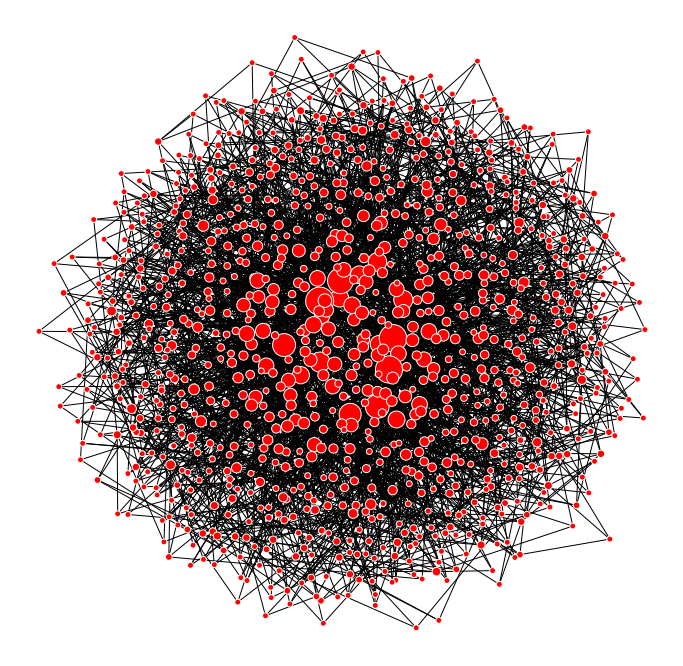

In [88]:
graf_abra(G)

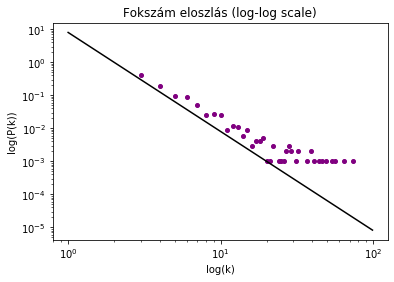

In [98]:
k_distrib(G, fit_line=True, expct_lo=1, expct_hi=100, expct_const=8)